In [95]:
import numpy as np
import matplotlib.pyplot as plt
from modules import Module, Sequential, Criterion

Implementaion of basic neural network on numpy, understanding main concepts of nn -> backpropogation, batch norm, dropout

In [96]:
class Linear(Module):
    """
    A module which applies a linear transformation 
    A common name is fully-connected layer, InnerProductLayer in caffe. 
    
    The module should work with 2D _input of shape (n_samples, n_feature).
    """
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()
       
        # This is a nice initialization
        # W - weights, b - bias
        stdv = 1./np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size = (n_out, n_in))
        self.b = np.random.uniform(-stdv, stdv, size = n_out)
        
        # grads = 0
        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)
        
    def updateOutput(self, _input):
        # Your code goes here. ################################################
        self.output = np.einsum("ij,jk->ik", _input, self.W) + self.b
        # print( "x_0 -> x_1 = {}".format(self.output))
        return self.output
    
    def updateGradInput(self, _input, gradOutput):
        # Your code goes here. ################################################

        self.gradInput = np.einsum("ij,jk->ik", gradOutput, self.W.T)
        # print( "parameters of Linear = {}, {}".format(self.W, self.b))
        return self.gradInput
    
    def accGradParameters(self, _input, gradOutput):
        # Your code goes here. ################################################
        # self.gradW = ... ; self.gradb = ...

        #dL/dw = dL/dY * dY/dLogSoftMax * dLogSoftMax/dX_1 * dX_1/dw  X_1 = X_0*w + b -> dX_1/dw = X_0
        self.gradW += np.dot(_input.T, gradOutput)
        #dL/dw = dL/dY * dY/dLogSoftMax * dLogSoftMax/dX_1 * dX_1/db  X_1 = X_0*w + b -> dX_1/db = 1
        self.gradb += np.sum(gradOutput, axis=0)
    
    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)
        
    def getParameters(self):
        return [self.W, self.b]
    
    def getGradParameters(self):
        return [self.gradW, self.gradb]
    
    def __repr__(self):
        s = self.W.shape
        q = 'Linear %d -> %d' %(s[1],s[0])
        return q

In [97]:
class Sigmoid(Module):
    def __init__(self):
        super(Sigmoid, self).__init__()

    def forward(self, input):
        # Calculate sigmoid activation during forward pass
        self.output = 1 / (1 + np.exp(-input))
        return self.output

    def backward(self, input, grad_output):
        # Calculate gradient of the sigmoid function during backward pass
        self.gradInput = self.output * (1 - self.output) * grad_output
        return self.gradInput
    
    def __repr__(self):
        return "Sigmoid"

In [98]:
class SoftMax(Module):
    def __init__(self):
        super(SoftMax, self).__init__()

    def forward(self, input):
        # Calculate softmax
        exp_input = np.exp(input - np.max(input, axis=1, keepdims=True))
        self.output = exp_input / np.sum(exp_input, axis=1, keepdims=True)
        return self.output

    def backward(self, input, gradOutput):
        # Calculate gradient of softmax
        softmax_output = self.forward(input)

        # Compute the Jacobian matrix
        n_feats = input.shape[1]
        jacobian = np.einsum('ij,ik->ijk', softmax_output, softmax_output)  # Outer product for each example

        # Create the (n_feats, n_feats) identity matrix
        identity_matrix = np.eye(n_feats)

        # Subtract the outer product from the identity matrix
        self.gradInput = identity_matrix - jacobian

        # Multiply by the gradient of the loss with respect to the softmax output
        self.gradInput = np.einsum('ijk,ik->ij', self.gradInput, gradOutput)
        # print("gradsoftmax {}".format( self.gradInput ))
        return self.gradInput

    def __repr__(self):
        return "SoftMax"

In [99]:
class LogSoftMax(Module):
    def __init__(self):
         super(LogSoftMax, self).__init__()
    
    def updateOutput(self, _input):
        # start with normalization for numerical stability
        _input = np.subtract(_input, _input.max(axis=1, keepdims=True))

        _input = np.exp(_input)
        sum_exp_input = np.sum(_input, axis=1, keepdims=True)

        # Avoid log(0) by adding a small constant
        epsilon = 1e-15
        self.output = np.log(_input + epsilon / (sum_exp_input + epsilon))
        # print( "Output for softmax = {}, {}, {}".format(_input[:5], sum_exp_input, self.output))

        return self.output

    def updateGradInput(self, _input, gradOutput):
        # dL/dX = dL/dY * dY/dX where Y = LogSoftmax(X)
        softmax_output = np.exp(_input - np.max(_input, axis=1, keepdims=True))
        softmax_output /= np.sum(softmax_output, axis=1, keepdims=True)

        # Calculate gradient of log softmax
        self.gradInput = gradOutput - np.sum(gradOutput * softmax_output, axis=1, keepdims=True)
        return self.gradInput

        # print( "gradInput of LogSoftMax = {}".format(self.gradInput))
        return self.gradInput
    
    def __repr__(self):
        return "LogSoftMax"

ReLU - Activation function, cheap to calculate, replace weights < 0 with 0.

In [100]:
class ReLU(Module):
    def __init__(self):
         super(ReLU, self).__init__()
    
    def updateOutput(self, _input):
        self.output = np.maximum(_input, 0)
        print( self.output )
        return self.output
    
    def updateGradInput(self, _input, gradOutput):
        self.gradInput = np.multiply(gradOutput , _input > 0)
        return self.gradInput
    
    def __repr__(self):
        return "ReLU"

In [101]:
class LeakyReLU(Module):
    def __init__(self, slope = 0.03):
        super(LeakyReLU, self).__init__()
            
        self.slope = slope
        
    def updateOutput(self, _input):
        # Your code goes here. ################################################

        return self.output
    
    def updateGradInput(self, _input, gradOutput):
        # Your code goes here. ################################################

        return self.slope * (1 - mask) * gradOutput + mask * gradOutput
    
    def __repr__(self):
        return "LeakyReLU"

In [102]:
class ClassNLLCriterionUnstable(Criterion):
    EPS = 1e-15
    def __init__(self):
        a = super(ClassNLLCriterionUnstable, self)
        super(ClassNLLCriterionUnstable, self).__init__()
        
    def updateOutput(self, _input, target): 
        
        # Use this trick to avoid numerical errors
        _input_clamp = np.clip(_input, self.EPS, 1 - self.EPS)
        
        # Your code goes here. ################################################

        return self.output

    def updateGradInput(self, _input, target):
        
        # Use this trick to avoid numerical errors
        _input_clamp = np.clip(_input, self.EPS, 1 - self.EPS)
                
        # Your code goes here. ################################################

        return self.gradInput
    
    def __repr__(self):
        return "ClassNLLCriterionUnstable"

In [103]:
class ClassNLLCriterion(Criterion):
    def __init__(self):
        super(ClassNLLCriterion, self).__init__()

    def updateOutput(self, _input, target):
        epsilon = 1e-15

        # Clip the probabilities
        _input_clipped = np.clip(_input, epsilon, 1 - epsilon)

        # Get the log probabilities for the true class labels
        log_probabilities = np.log(_input_clipped)

        # Calculate the negative log likelihood loss -log(p)
        self.output = -np.mean(log_probabilities[target == 1].reshape(-1, 1))
        
        # print( "LossInput = {}".format(log_probabilities, target))
        return self.output

    def updateGradInput(self, _input, target):
        epsilon = 1e-15

        # Clip the probabilities
        _input_clipped = np.clip(_input, epsilon, 1 - epsilon)

        # Calculate the gradient of the negative log likelihood loss
        self.gradInput = -target / _input_clipped

        return self.gradInput
    
    def __repr__(self):
        return "ClassNLLCriterion"

In [104]:
class BinaryCrossEntropyCriterion(Criterion):
    def __init__(self):
        super(BinaryCrossEntropyCriterion, self).__init__()

    def updateOutput(self, _input, target):
        epsilon = 1e-15

        # Clip the probabilities to avoid log(0)
        _input_clipped = np.clip(_input, epsilon, 1 - epsilon)

        # Calculate the binary cross-entropy loss
        self.output = -np.mean(target * np.log(_input_clipped) + (1 - target) * np.log(1 - _input_clipped))

        return self.output

    def updateGradInput(self, _input, target):
        epsilon = 1e-15

        # Clip the probabilities to avoid division by zero
        _input_clipped = np.clip(_input, epsilon, 1 - epsilon)

        # Calculate the gradient of the binary cross-entropy loss
        self.gradInput = -target/_input_clipped + (1-target)/(1-_input_clipped)
        # print( "Output for logloss = {}, {}".format(_input[:5], self.output[:5]))

        return self.gradInput

In [105]:
def simple_sgd(variables, gradients, config, state):  
    # 'variables' and 'gradients' have complex structure, accumulated_grads will be stored in a simpler one
    state.setdefault('accumulated_grads', {})
    
    var_index = 0 
    for current_layer_vars, current_layer_grads in zip(variables, gradients): 
        for current_var, current_grad in zip(current_layer_vars, current_layer_grads):
            
            current_var -= config['learning_rate'] * current_grad
            var_index += 1   

True

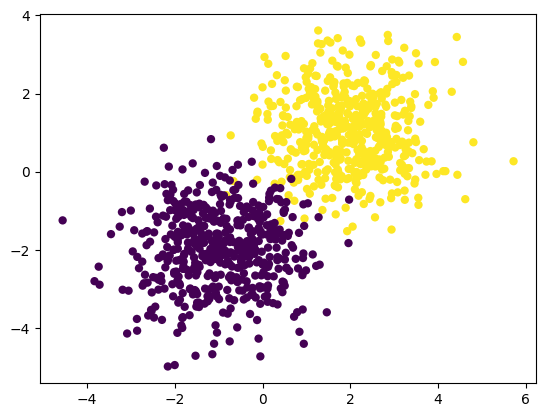

In [106]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,1.1])
X2 = np.random.randn(N,2) + np.array([-1.0,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])
Y = np.array(Y, dtype=np.int32)

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')
len(X) == len(Y)

In [107]:
net = Sequential()
net.add(Linear(2, 2))
net.add(SoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
SoftMax



In [108]:
# Optimizer params
optimizer_config = {'learning_rate' : 3e-4}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 64
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
    print( len(X), len(Y))
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

Training nn

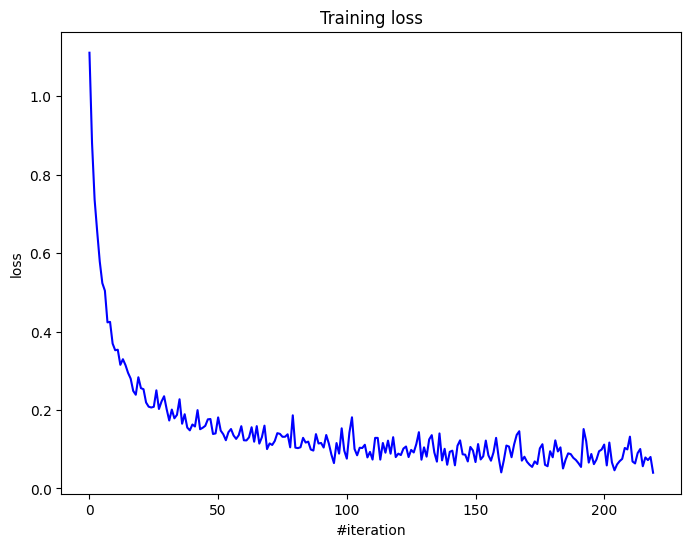

Current loss: 0.040229
[1.1111585125499654, 0.881129028740491, 0.736843998011665, 0.6553089891111589, 0.5787494924597374, 0.5237052394513215, 0.5042779692331641, 0.42363971610237794, 0.4248759921053316, 0.3695451303869126, 0.35255579858070984, 0.3538401829224729, 0.31537315956628276, 0.32966482898834737, 0.3145915178308872, 0.2947954648198726, 0.2803653271447047, 0.24883679702006878, 0.23906001443060781, 0.28365970374781435, 0.2559055126387584, 0.25314219799135806, 0.21927741119243035, 0.20863690795823836, 0.20650281566921183, 0.20836056619327353, 0.2502988467058193, 0.20275397099177006, 0.2218311936343101, 0.2352268888113449, 0.20214397192490163, 0.1733550400916648, 0.2012553206356865, 0.17896584546326416, 0.18778694949515767, 0.22752771927094934, 0.16511933828610037, 0.1893900916371949, 0.15534680315080487, 0.14828101447324862, 0.16320479005108024, 0.15810640388715347, 0.19982886719333698, 0.15114106496493154, 0.15484127691326605, 0.15978651770339045, 0.17632730474851044, 0.177162425

In [109]:
from sklearn.model_selection import train_test_split
print( len(X), len(Y))
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=True, test_size=0.3 )
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train, Y_train), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        print( "predictions", predictions)
        loss = criterion.forward(predictions, y_batch)
        print( loss )
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        # Update weights
        simple_sgd(net.getParameters(), 
                   net.getGradParameters(), 
                   optimizer_config,
                   optimizer_state)      
        
        loss_history.append(loss)
    
    # Visualize
    from IPython.display import clear_output
    clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss) 
print(loss_history)

The loss has too many fluctuations because I am using here simple sgd. We can use sgd with momentum, Nesterov momentum where idea is accumulating grads to reduce fluctuations.

Comparing perfomance with already implemented models from sklearn

In [110]:
from sklearn.metrics import accuracy_score

net.train = False
net.zeroGradParameters()
        
# Forward
predictions_prob = net.forward(X_test)
print( len(predictions_prob) )
predictions = (predictions_prob > 0.5).astype(int)
# print( predictions[:5], Y_test[:5])
accuracy_score(predictions, Y_test)

300


0.99

In [111]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression().fit( X_train, Y_train[:,0])
lg.score( X_test, Y_test[:,0])

0.98

Now lets verify that NN can catch complex non-linear patterns. 

[[-0.29028521  1.08540942]
 [-0.59215783  0.62664297]
 [ 0.94860413  0.9884842 ]
 ...
 [ 0.20439807  0.19872048]
 [-0.67064235  0.55646594]
 [ 1.07154377  0.54596939]]


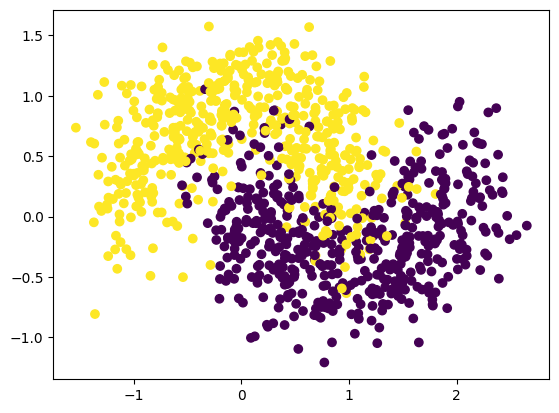

In [112]:
from sklearn.datasets import make_moons

data = make_moons(n_samples=1000, shuffle=True, noise=0.28)
x_moon, y_moon = data
y_moon = np.eye(2)[y_moon]
print(x_moon)
plt.scatter(x_moon[:,0], x_moon[:,1], c = y_moon[:,0])

In [113]:
net1 = Sequential()
net1.add(Linear(2,2))
net1.add(ReLU())
net1.add(Linear(2,2))
net1.add(SoftMax())

net1

Linear 2 -> 2
ReLU
Linear 2 -> 2
SoftMax

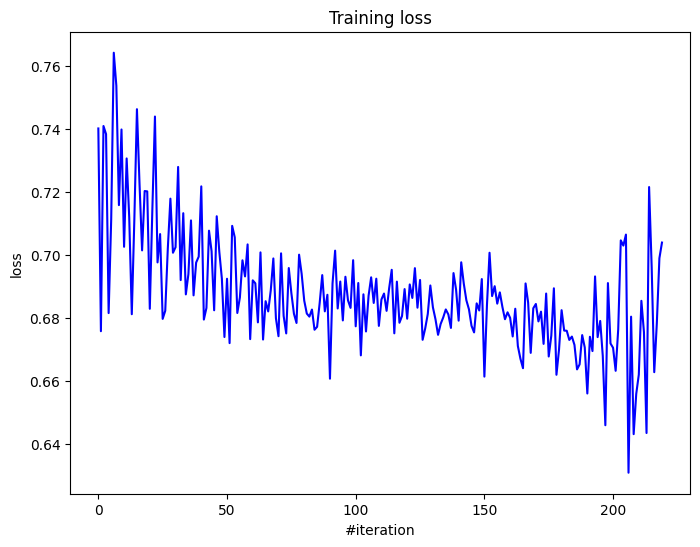

Current loss: 0.703937
[0.7402109832034434, 0.6757547121152392, 0.7409843513555658, 0.7384281890147402, 0.6815199182817152, 0.7113648223534526, 0.7642900713018267, 0.7537696031182135, 0.7158383118513758, 0.7398869754593145, 0.7025939845715705, 0.730679971709836, 0.7119864705175203, 0.6811562009781426, 0.7115332791923328, 0.746338303424664, 0.7226560102295376, 0.7014504064645664, 0.720319733536374, 0.7202056361287477, 0.6828803802223322, 0.7147883955523145, 0.7440061678922458, 0.6976290313294538, 0.7066325638546527, 0.6796808034390549, 0.6822610909305102, 0.7021504767176707, 0.7178955658541122, 0.7006979003635658, 0.7024515212533792, 0.7279784040733274, 0.6920023486974975, 0.7132720423982353, 0.6874615613360908, 0.6939274640389285, 0.7109764779210688, 0.6871515970484616, 0.6975681230722262, 0.6994609761762658, 0.7217994701412866, 0.679458290022438, 0.683149669992831, 0.7077132969224681, 0.7011883189019354, 0.6824085651189404, 0.7123003336140814, 0.701060626669977, 0.692437149667465, 0.6

In [114]:
X_train_m, X_test_m, Y_train_m, Y_test_m = train_test_split(x_moon, y_moon, shuffle=True, test_size=0.3 )
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train_m, Y_train_m), batch_size):
        
        net1.zeroGradParameters()
        
        # Forward
        predictions = net1.forward(x_batch)
        print( "predictions", predictions)
        loss = criterion.forward(predictions, y_batch)
        print( loss )
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net1.backward(x_batch, dp)
        # Update weights
        simple_sgd(net1.getParameters(), 
                   net1.getGradParameters(), 
                   optimizer_config,
                   optimizer_state)      
        
        loss_history.append(loss)
    
    # Visualize
    from IPython.display import clear_output
    clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss) 
print(loss_history)

In [115]:
# Forward
predictions_prob = net1.forward(X_test_m)
clear_output(wait=True)  
print( len(predictions_prob) )
predictions = (predictions_prob > 0.5).astype(int)
# print( predictions[:5], Y_test[:5])
print(accuracy_score(predictions, Y_test))

model = LogisticRegression().fit( X_train_m, Y_train_m[:,0])
model.score( X_test_m, Y_test_m[:,0])


300
0.5


0.85

In this example NN shows bad perfomance but it is because of simplicity. In real tasks we never write NN from scratch and usually use tools like torch with a lot of optimizations, methods are that increase quality of models and speed of creating models.